### Notebook to calculate the area-weighted annual SST within Aotearoa's Exclusive Economic Zone

data sources: 

- ERSST: [http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc](http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc)
- shapefile with the World's EEZ: [https://www.marineregions.org/downloads.php](https://www.marineregions.org/downloads.php ) 

### imports 

In [1]:
%matplotlib inline

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs

### rioxarray for experimental clipping 
import rioxarray

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
import regionmask

In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

In [4]:
import sys

In [5]:
sys.path.append('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/')

In [6]:
from ICU_Water_Watch import utils, geo

### reads the shapefile containing the world's EEZ as polygons

In [7]:
shp = gpd.read_file('../data/World_EEZ_v11_20191118_HR_0_360/eez_v11_0_360.shp') 

In [8]:
shp.head()

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
0,8357.0,Kuwaiti Exclusive Economic Zone,2115.0,200NM,2115.0,Kuwait,KWT,Kuwait,0.0,0.0,...,KWT,None,None,414.0,NaN,NaN,414.0,NaN,NaN,"MULTIPOLYGON (((47.97083 29.99681, 47.97161 29..."
1,8310.0,Norfolk Island Exclusive Economic Zone,8591.0,200NM,2147.0,Norfolk Island,NFK,Australia,0.0,0.0,...,AUS,None,None,36.0,NaN,NaN,574.0,NaN,NaN,"POLYGON ((169.42984 -25.93061, 169.43003 -25.9..."
2,8373.0,Syrian Exclusive Economic Zone,3384.0,200NM,3384.0,Syria,SYR,Syria,0.0,0.0,...,SYR,None,None,760.0,NaN,NaN,760.0,NaN,NaN,"POLYGON ((35.91810 35.92989, 35.91752 35.92882..."
3,62596.0,Colombian Exclusive Economic Zone (Serrana),5770.0,200NM,2175.0,Serrana Bank,None,Colombia,0.0,0.0,...,COL,None,None,170.0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((279.76139 14.67328, 279.76346 14.673..."
4,8343.0,Mauritian Exclusive Economic Zone,8614.0,200NM,8614.0,Republic of Mauritius,MUS,Republic of Mauritius,0.0,0.0,...,MUS,None,None,480.0,NaN,NaN,480.0,NaN,NaN,"POLYGON ((58.24359 -23.80956, 58.23972 -23.801..."


### select only NZ's economic zone

In [9]:
shp = shp.query("GEONAME == 'New Zealand Exclusive Economic Zone'")

In [10]:
shp

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
205,8455.0,New Zealand Exclusive Economic Zone,2227.0,200NM,2227.0,New Zealand,NZL,New Zealand,0.0,0.0,...,NZL,None,None,554.0,NaN,NaN,554.0,NaN,NaN,"POLYGON ((180.00000 -52.95699, 180.00000 -52.9..."


<AxesSubplot:>

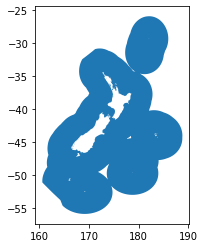

In [11]:
shp.plot()

### save to file for later use

In [12]:
shp.to_file('../data/NZ_EEZ.GeoJSON', driver='GeoJSON')

### Now reads in the ERSST dataset (from the NOAA's openDAP server)

In [13]:
url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"	

In [14]:
ds = xr.open_dataset(url, drop_variables=["time_bnds"])

### select period here 

In [15]:
ds = ds.sel(time=slice('1950','2022'))

In [16]:
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 865)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-01-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-03-01
    DODS_EXTRA.Unlimited_Dimension:  time

### flip the latitudes 

In [17]:
ds = ds.sortby('lat')

### quick plots to check values 

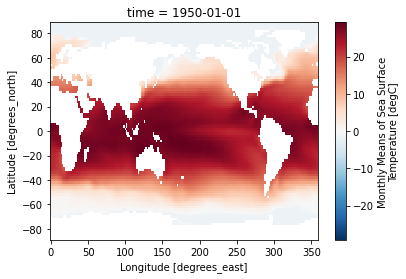

In [18]:
ds['sst'][0,:,:].plot()

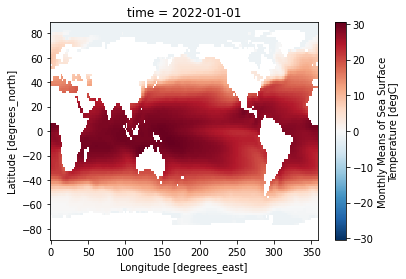

In [19]:
ds['sst'][-1,:,:].plot()

### clipping the dataset using rioxarray 

In [20]:
rio_clip = False

In [21]:
if rio_clip: 
    
    from shapely.geometry import mapping
    
    
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    
    clipped = ds.rio.clip(shp.geometry.apply(mapping), shp.crs, drop=False)
    
    clipped['sst'][0,:,:].plot()

## selects domain

In [22]:
ds = ds.sel(lat=slice(-58, -24), lon=slice(159., 191.))

## calculate climatology 

In [23]:
clim = ds.sel(time=slice('1981','2010'))

In [24]:
clim = clim.groupby(clim.time.dt.month).mean('time')

### calculate anomalies 

In [25]:
anomalies = ds.groupby(ds.time.dt.month) - clim

### interpolate the NaNs

In [26]:
sst_interp = utils.interpolate_NaN_da(anomalies['sst'])

### interpolate to higher resolution 

In [27]:
sst_interp = sst_interp.to_dataset(name='sst')

In [28]:
sst_interp = utils.interp(sst_interp, interp_factor=10)

### mask ?

In [29]:
sst_interp = geo.make_mask_from_gpd(sst_interp, shp, insert=True)

### the dataset is now subsetted 

<GeoAxesSubplot:title={'center':'time = 2022-01-01, month = 1'}, xlabel='lon', ylabel='lat'>

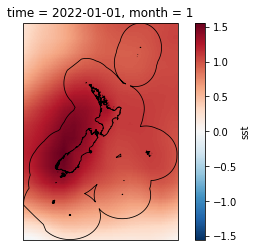

In [30]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
sst_interp['sst'][-1,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)

### mask

<GeoAxesSubplot:xlabel='lon', ylabel='lat'>

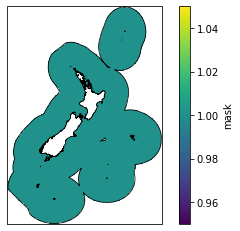

In [31]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
sst_interp['mask'].plot(ax=ax, transform=ccrs.PlateCarree())
shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)

### multiply the SSTs by the mask 

In [32]:
sst_interp['sst_masked'] = sst_interp['sst'] * sst_interp['mask']

<GeoAxesSubplot:title={'center':'time = 2022-01-01, month = 1'}, xlabel='lon', ylabel='lat'>

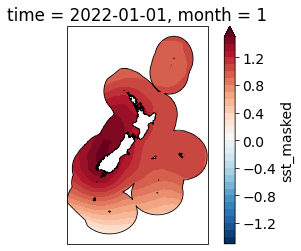

In [54]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
sst_interp['sst_masked'][-1,:,:].plot.contourf(ax=ax, levels=np.arange(-1.5, 1.6, 0.1), transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)

<GeoAxesSubplot:title={'center':'time = 2022-01-01, month = 1'}, xlabel='lon', ylabel='lat'>

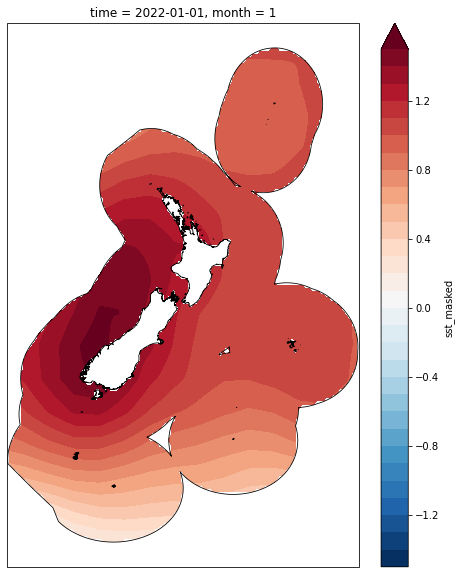

In [34]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(8,10))
sst_interp['sst_masked'][-1,:,:].plot.contourf(ax=ax, levels=np.arange(-1.5, 1.6, 0.1), transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)

In [35]:
fig = plt.figure(figsize=(2,10), facecolor='w')

<Figure size 144x720 with 0 Axes>

In [50]:
def custom_func_map(ds, fig, tt, *args, **kwargs): 
    
    cbar_kwargs = {'shrink':0.5, 'pad':0.01, 'label':'℃', 'extend':'neither'}
    
    ax = fig.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    date =  sst_interp.time.to_index()[tt]
    
    ds.isel(time=tt).plot.contourf(ax=ax, vmin=-1.5, vmax=1.5, levels=np.arange(-1.5, 1.6, 0.1), transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, cbar_kwargs=cbar_kwargs)
    
    shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)
    
    ax.coastlines(resolution='10m')
    
    ax.set_title(f"Sea Surface Temperature anomalies, {date:%Y-%m}")
    
    ax.axis('off')
    
    return None

In [55]:
from xmovie import Movie

In [56]:
# mov_custom = Movie(sst_interp['sst_masked'].isel(time=slice(-100,None)).chunk({'time':1}), custom_func_map)
mov_custom = Movie(sst_interp['sst_masked'].chunk({'time':1}), custom_func_map)

In [ ]:
mov_custom.save('../outputs/movie.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/865 [00:00<?, ?it/s]

### number of grid points inside the EEZ

In [ ]:
len(sst_interp['sst_masked'].stack(z=('lat','lon')).dropna('z')['z'])

### creates the weights (cosine of the latitude)

In [ ]:
weights = np.cos(np.deg2rad(sst_interp.lat))
weights.name = "weights"
weights

### weighted mean

In [ ]:
sst_weighted = sst_interp['sst_masked'].weighted(weights)

In [ ]:
sst_weighted_mean = sst_weighted.mean(['lat','lon'])

### non weighted mean for comparison 

In [ ]:
sst_mean = sst_interp['sst_masked'].mean(['lat','lon'])

### difference between weighted and un-weighted mean 

In [ ]:
(sst_weighted_mean - sst_mean).plot()

### it's systematically warmer, which makes sense as the weights are larger as you go from S to N 

### plot of the area weigthed mean time-series for NZ's EEZ 

In [ ]:
sst_weighted_mean.plot()

### check the seasonal cycles of both unweighted and weighted mean

In [ ]:
f, ax = plt.subplots()
sst_weighted_mean.groupby(sst_weighted_mean.time.dt.month).mean().plot(ax=ax, color='r')
sst_mean.groupby(sst_mean.time.dt.month).mean().plot(ax=ax, color='b')

### calculates the annual averages ('raw' data)

In [ ]:
sst_weighted_mean_annual = sst_weighted_mean.resample({'time':'A'}).mean()

In [ ]:
sst_weighted_mean_annual.plot()

In [ ]:
sst_weighted_mean_annual = sst_weighted_mean_annual.to_pandas()

In [ ]:
sst_weighted_mean_annual = sst_weighted_mean_annual.to_frame(name='NZ_SST')

### sort 

In [ ]:
sorted_sst_weighted_mean_annual = sst_weighted_mean_annual.sort_values(ascending=False, by='NZ_SST')

In [ ]:
sorted_sst_weighted_mean_annual.head()

In [ ]:
sorted_sst_weighted_mean_annual.loc[:,'rank'] = np.arange(len(sorted_sst_weighted_mean_annual)) + 1

In [ ]:
sorted_sst_weighted_mean_annual.head()

### calculates the climatology, to express values in terms of anomalies 

In [ ]:
climo = sst_weighted_mean_annual.loc['1981':'2010',:].mean()

In [ ]:
sst_weighted_mean_annual_anoms = sst_weighted_mean_annual - climo

In [ ]:
sst_weighted_mean_annual_anoms.plot()

In [ ]:
sst_weighted_mean_annual_anoms.sort_values(ascending=False, by='NZ_SST').head()

### rename, concatenate and save to disk 

In [ ]:
sst_weighted_mean_annual_anoms.columns = ['NZ_EEZ_SST_anomalies']

In [ ]:
sst_weighted_mean_annual.columns = ['NZ_EEZ_SST']

In [ ]:
sst = pd.concat([sst_weighted_mean_annual, sst_weighted_mean_annual_anoms], axis=1)

In [ ]:
sst.to_csv('/home/nicolasf/Desktop/NZ_EEZ_SST_annual.csv')